In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from tqdm import tqdm
import joblib

import random
random.seed(2020)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import log_loss
import lightgbm as lgb
from datetime import datetime, timedelta

In [2]:
train = pd.read_pickle('train.pickle')
test = pd.read_pickle('test.pickle')
train_label = train['label']

In [3]:
var_model = list(pd.read_csv('var_model.csv')['var'])

In [4]:
lbl = pd.DataFrame({'label' : train['label']})

In [5]:
lbl = pd.DataFrame({'label' : train['label']})
lbl['freq'] = lbl['label'].map(lbl['label'].value_counts().to_dict())

In [6]:
print(train.shape)
print(test.shape)

(38088, 4532)
(33120, 4531)


Fold : 0
training shape : (30470, 4530)
validation shape : (7618, 4530)
test shape : (33120, 4530)
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0243488	valid_1's multi_logloss: 0.174348
[200]	training's multi_logloss: 0.00277179	valid_1's multi_logloss: 0.10023
[300]	training's multi_logloss: 0.00121438	valid_1's multi_logloss: 0.0837675
[400]	training's multi_logloss: 0.000761752	valid_1's multi_logloss: 0.0760415
[500]	training's multi_logloss: 0.000552647	valid_1's multi_logloss: 0.0712287
[600]	training's multi_logloss: 0.000433255	valid_1's multi_logloss: 0.0678438
[700]	training's multi_logloss: 0.00035627	valid_1's multi_logloss: 0.0652702
[800]	training's multi_logloss: 0.000302549	valid_1's multi_logloss: 0.0632227
[900]	training's multi_logloss: 0.000262972	valid_1's multi_logloss: 0.06156
[1000]	training's multi_logloss: 0.000232612	valid_1's multi_logloss: 0.0601425
Did not meet early stopping. Best iteration is:
[1000]	tr

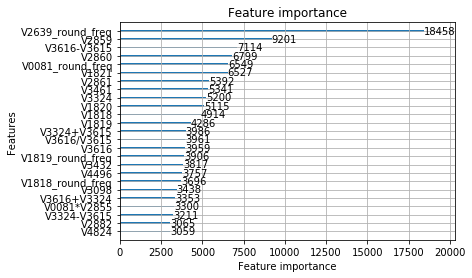

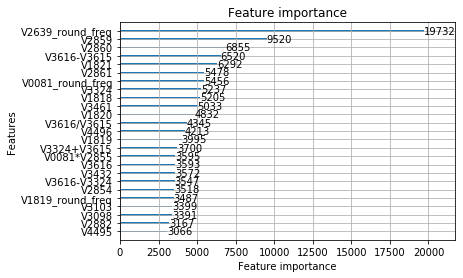

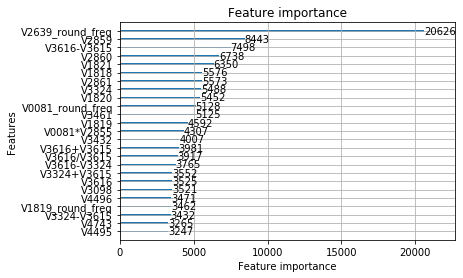

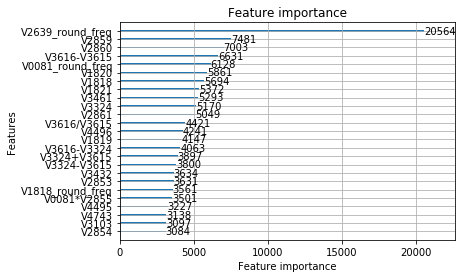

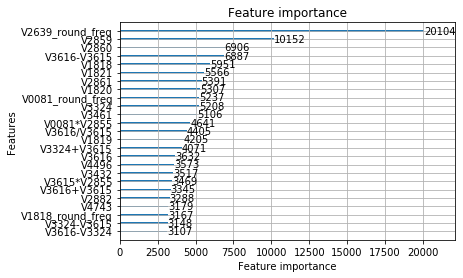

In [7]:
%%time
# lbl_dup = train[['id','label']].drop_duplicates().reset_index(drop=True)
# lbl_dup['label_freq'] = lbl_dup['label'].map(lbl_dup['label'].value_counts().to_dict())

from sklearn.model_selection import StratifiedKFold
stk = StratifiedKFold(n_splits=5,random_state = 1995,shuffle=True)

prediction = []

for fold_, (tr_id, vl_id) in enumerate(stk.split(lbl,lbl['freq'])):
    print('Fold :',fold_)
    
    x_tr = train.iloc[tr_id,:]
    x_vl = train.iloc[vl_id,:]
    
    y_tr = x_tr['label']
    y_vl = x_vl['label']
    
    print('training shape :', x_tr[var_model].shape)
    print('validation shape :', x_vl[var_model].shape)
    print('test shape :', test[var_model].shape)

    lgb_tr = lgb.Dataset(x_tr[var_model], label=y_tr)
    lgb_vl = lgb.Dataset(x_vl[var_model], label=y_vl)

    watchlist_1 = [lgb_tr, lgb_vl]
    watchlist_2 = [lgb_vl, lgb_tr]

    params = {
        "objective": "multiclass",
        "boosting": "gbdt",
        "num_leaves": 40,
        "learning_rate": 0.05,
        "feature_fraction": 0.85,
        "reg_lambda": 2,
        "metric": "multiclass",
        "num_class" : 198
    }

    lgb_model = lgb.train(params, train_set=lgb_tr, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=100, early_stopping_rounds=100)
    
    print('save model')
    joblib.dump(lgb_model, 'lgb_'+str(fold_)+'.pkl')

    print('predicting')
    prediction += [pd.DataFrame(lgb_model.predict(test[var_model]))]
    
    lgb.plot_importance(lgb_model,max_num_features = 25)

In [10]:
test_id = test['id']

In [11]:
temp = prediction[0]
pred1 = pd.concat([pd.DataFrame(test_id),temp],axis=1).groupby('id').mean().reset_index()

temp = prediction[1]
pred2 = pd.concat([pd.DataFrame(test_id),temp],axis=1).groupby('id').mean().reset_index()

temp = prediction[2]
pred3 = pd.concat([pd.DataFrame(test_id),temp],axis=1).groupby('id').mean().reset_index()

temp = prediction[3]
pred4 = pd.concat([pd.DataFrame(test_id),temp],axis=1).groupby('id').mean().reset_index()

temp = prediction[4]
pred5 = pd.concat([pd.DataFrame(test_id),temp],axis=1).groupby('id').mean().reset_index()


sub = (pred1 + pred2 + pred3 + pred4 + pred5)/5

sub['id'] = sub['id'].astype('int')

In [13]:
sub.to_csv('half_half_base3_stratified.csv',index=False)

In [23]:
time_now = datetime.now() + timedelta(hours = 9)
submission_name = str(time_now)[:16] + '_submission.csv'
sub.to_csv(submission_name,index=False)

In [25]:
print(pred1.shape)
print(pred2.shape)
print(pred3.shape)

(720, 199)
(720, 199)
(720, 199)
